<a href="https://colab.research.google.com/github/the-astronot/intro_to_ai/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Reqs

In [1]:
# Mass imports
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
# I'm gonna need this later
def translate_y(y):
  value = ((np.log(y) / np.log(2))+4)
  return value

def untranslate_y(y_mod):
  value = np.float_power(2,(y_mod)-4)
  return value

def perc_error(pred,reality):
  assert(len(pred) == len(reality))
  total = len(reality)
  diff = abs(reality-pred)
  perc_off = diff/reality
  summ = perc_off.sum()
  return summ/float(total)

# Topic
For this homework, while I am abandoning the galaxy classification that I have used previously, space-related problems continue to fascinate me, so I've found an asteroid dataset.

# Open Asteroid Dataset
I found the [Open Asteroid Dataset](https://www.kaggle.com/datasets/basu369victor/prediction-of-asteroid-diameter) on Kaggle. In this homework, I will attempt to determine the diameter of a given asteroid based on other features that are easier to observe.

# Background
Having no prior experience properly using Neural Networks or any of the python libraries related to them, I had to read up on a few articles/some documentation, which I have enumerated below:

1. [General Intro to NN in Python from Medium](https://betterprogramming.pub/how-to-build-2-layer-neural-network-from-scratch-in-python-4dd44a13ebba)
2. [Guide on Using TensorFlow and Keras for a Basic Neural Network](https://www.geeksforgeeks.org/implementing-neural-networks-using-tensorflow/)
3. [Keras Documentation](https://www.tensorflow.org/api_docs/python/tf/keras)

Being very new to all of this, when I did my original searching around for this homework, I tried to find a library that would automate as much of the process for me as possible. My first reference links to a guide for rolling up a NN mostly from scratch. This was useful for getting more comfortable with the overall idea of what I was trying to accomplish. It was also a nice stepping stone from the equations discussed in class to actual code.

After some more searching, I came across another guide using the keras module inside of TensorFlow library to get around writing all of the code yourself. So for my implementation, I started off adhering to that guide and then made changes as required to better the outcome of the model.

Some of those changes involved messing around with the different activation functions, loss functions, and optimizers outlined in the documentation found in my third reference. I found that documentation very useful for learning to use all of the different hyperparameters involved as well.

# Implementation
Now for the implementation...

In [3]:
# Loading the dataset
df = pd.read_csv('Asteroid_Updated.csv')
# Take a peek at the data
pd.set_option('display.max_columns', None)
df.head(10)

,name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,neo,pha,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,0,1002,3.34,N,N,939.4,964.4 x 964.2 x 891.8,0.0900,9.074170,62.6284,0.713,0.426,NaN,C,G,0.12,1.594780,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,0,8490,4.13,N,N,545,582x556x500,0.1010,7.813200,14.3000,0.635,0.284,NaN,B,B,0.11,1.233240,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,0,7104,5.33,N,N,246.596,NaN,0.2140,7.210000,NaN,0.824,0.433,NaN,Sk,S,0.32,1.034540,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,0,9325,3.20,N,N,525.4,572.6 x 557.2 x 446.4,0.4228,5.342128,17.8000,0.782,0.492,NaN,V,V,0.32,1.139480,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,0,2916,6.85,N,N,106.699,NaN,0.2740,16.806000,NaN,0.826,0.411,NaN,S,S,NaN,1.095890,MBA,0.238632,1508.600458,282.366289
5,Hebe,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329.0,0,6034,5.71,N,N,185.18,NaN,0.2679,7.274500,NaN,0.822,0.399,NaN,S,S,0.24,0.973965,MBA,0.260972,1379.459705,86.197923
6,Iris,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452.0,0,5206,5.51,N,N,199.83,NaN,0.2766,7.139000,NaN,0.855,0.484,NaN,S,S,NaN,0.846100,MBA,0.267535,1345.619196,140.419656
7,Flora,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655.0,0,2744,6.49,N,N,147.491,NaN,0.2260,12.865000,NaN,0.885,0.489,NaN,NaN,S,0.28,0.874176,MBA,0.301681,1193.313717,194.882895
8,Metis,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821.0,0,2649,6.28,N,N,190,NaN,0.1180,5.079000,NaN,0.858,0.496,NaN,NaN,S,0.17,1.106910,MBA,0.267484,1345.875362,276.861623
9,Hygiea,3.141539,0.112461,3.831560,283.202167,312.315206,2.788240,3.494839,5.568291,62175.0,0,3409,5.43,N,N,407.12,NaN,0.0717,27.630000,7.0000,0.696,0.351,NaN,C,C,NaN,1.778390,MBA,0.177007,2033.818284,152.184851


# Exploratory Data Analysis
That's a lot of features. I'll check for N/A values.

In [4]:
df.isna().describe()

,name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,neo,pha,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
count,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714,839714
unique,2,2,1,1,1,1,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2
top,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False
freq,817747,839712,839714,839714,839714,839714,839714,839708,839713,824240,838847,839714,837025,839708,823272,702078,839696,703305,820918,839700,838693,838735,839713,838048,838734,839595,823272,839714,839712,839708,839706


Well, that's a bit disconcerting. It would appear that the diameter is not null for only about 137,000 datapoints of the ~840,000 total. I guess that makes a good argument for the utility of the predictor. I expect that the number remaining should be enough to train the model sufficiently.

In [5]:
# Let's remove those entries with null diameters
df = df[df.diameter.isna()!=True]
df["diameter"] = df["diameter"].astype(float)
df.describe()

,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,rot_per,GM,BV,UB,IR,G,moid,n,per,ma
count,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137498.000000,137636.000000,136889.000000,137636.000000,136406.000000,11188.000000,1.400000e+01,1005.000000,965.000000,1.00,119.000000,137636.000000,137636.000000,1.376360e+05,137636.000000
mean,2.814613,0.145485,10.349182,169.827629,181.904551,2.402609,3.226618,4.884248,8969.818601,675.027740,15.177041,5.483228,0.130066,23.566011,7.821928e+00,0.768844,0.364108,-0.33,0.178739,1.420145,0.219640,1.783972e+03,183.116785
std,1.522740,0.077573,6.835111,102.713052,103.556464,0.516169,2.896374,25.532565,6165.176190,595.935104,1.407654,9.385735,0.109994,74.829904,1.678880e+01,0.088327,0.095707,NaN,0.134603,0.512241,0.056980,9.325769e+03,103.411497
min,0.626226,0.000489,0.021855,0.000738,0.004466,0.081882,0.999956,0.495569,1.000000,5.000000,3.200000,0.002500,0.001000,0.029952,2.100000e-09,0.580000,0.120000,-0.33,-0.250000,0.000166,0.000128,1.810067e+02,0.000517
25%,2.536714,0.089623,5.120506,82.334880,91.947943,2.068948,2.864438,4.040317,6291.000000,215.000000,14.400000,2.770000,0.053000,4.670000,1.022225e-03,0.700000,0.289000,-0.33,0.100000,1.082523,0.181231,1.475726e+03,94.301261
50%,2.750859,0.138543,9.389963,160.438430,183.669900,2.363897,3.167516,4.562581,7572.000000,496.000000,15.300000,3.956000,0.078000,7.560000,6.192500e-01,0.743000,0.360000,-0.33,0.190000,1.384935,0.216024,1.666483e+03,186.826667
75%,3.092537,0.191141,13.738588,256.268387,271.762261,2.685811,3.468608,5.438518,9731.000000,984.000000,16.100000,5.742000,0.188000,14.579500,6.500000e+00,0.850000,0.439000,-0.33,0.250000,1.699385,0.243948,1.986419e+03,271.468299
max,389.145964,0.984348,170.323647,359.990858,359.995174,40.465671,772.201080,7676.742943,72684.000000,9325.000000,29.900000,939.400000,1.000000,1880.000000,6.262840e+01,1.077000,0.655000,-0.33,0.600000,39.507000,1.988877,2.803930e+06,359.999979


That's better, but it looks like some columns aren't showing up. They're likely strings. Let me fix that.

In [6]:
df.describe(include=["O"])

,name,condition_code,neo,pha,extent,spec_B,spec_T,class
count,15124,137636,137636,137636,16,1370,965,137636
unique,15124,20,2,2,16,31,128,11
top,Ceres,0,N,N,964.4 x 964.2 x 891.8,S,S,MBA
freq,1,126194,136786,137415,1,368,329,126390


In [7]:
df["condition_code"] = df["condition_code"].astype(float)
df.condition_code.describe()

count    137636.000000
mean          0.485207
std           1.966078
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: condition_code, dtype: float64

In [8]:
# Transforming Y/N to 1/0 for neo and pha
df["neo_bool"] = 0
df.loc[df['neo'] == "Y", 'neo_bool'] = 1
df["pha_bool"] = 0
df.loc[df['pha'] == "Y", 'pha_bool'] = 1
df.drop('neo',axis=1,inplace=True)
df.drop('pha',axis=1,inplace=True)

## Dropped Data
I was prepared to convert the following features, but upon closer examination, they are all difficult to convert and also mostly N/A, so I ended up dropping them anyways.

- name is useless to the model.
- extent is composed of only 16 non N/A values, each of which are actually 3-dimensional bounds for the orbit of the asteroid.
- spec_B/spec_t are the spectral taxonomic types of the asteroids. I have no meaningful way to convert that to meaningful data to be a coherent feature.
- class is composed of 12 unique strings regarding the orbit class of the asteroid. I was originally going to drop it as well, but on second thought, I'd like to see what I can do to fix it. After all, at least it has values for each of the rows.

## Fixing class
First off, I have to get away from the variable "class". I've seen before that it makes python angry. Other than that though, I think I'll just assign integer values to the unique strings in ascending order. To the best of my understanding, having left linear models behind, the classifications I'm converting dont actually need to be linear, which is good, because after 20 minutes of googling I still can't seem to find exact definitions of the classifications.

In [9]:
df.drop('name',axis=1,inplace=True)
df.drop('extent',axis=1,inplace=True)
df.drop('spec_B',axis=1,inplace=True)
df.drop('spec_T',axis=1,inplace=True)

In [10]:
classes = {}
def assign_class(row):
  string = row['class']
  if string in classes:
    return classes[string]
  else:
    classes[string] = len(classes)
    return classes[string]

In [11]:
df['class_int'] = df.apply(assign_class, axis=1)
df.drop('class',axis=1,inplace=True)

# Check that everything was dropped correctly

In [12]:
df.describe()

,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,albedo,rot_per,GM,BV,UB,IR,G,moid,n,per,ma,neo_bool,pha_bool,class_int
count,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137636.000000,137498.000000,137636.000000,137636.000000,136889.000000,137636.000000,136406.000000,11188.000000,1.400000e+01,1005.000000,965.000000,1.00,119.000000,137636.000000,137636.000000,1.376360e+05,137636.000000,137636.000000,137636.000000,137636.000000
mean,2.814613,0.145485,10.349182,169.827629,181.904551,2.402609,3.226618,4.884248,8969.818601,0.485207,675.027740,15.177041,5.483228,0.130066,23.566011,7.821928e+00,0.768844,0.364108,-0.33,0.178739,1.420145,0.219640,1.783972e+03,183.116785,0.006176,0.001606,0.184530
std,1.522740,0.077573,6.835111,102.713052,103.556464,0.516169,2.896374,25.532565,6165.176190,1.966078,595.935104,1.407654,9.385735,0.109994,74.829904,1.678880e+01,0.088327,0.095707,NaN,0.134603,0.512241,0.056980,9.325769e+03,103.411497,0.078343,0.040039,0.837106
min,0.626226,0.000489,0.021855,0.000738,0.004466,0.081882,0.999956,0.495569,1.000000,0.000000,5.000000,3.200000,0.002500,0.001000,0.029952,2.100000e-09,0.580000,0.120000,-0.33,-0.250000,0.000166,0.000128,1.810067e+02,0.000517,0.000000,0.000000,0.000000
25%,2.536714,0.089623,5.120506,82.334880,91.947943,2.068948,2.864438,4.040317,6291.000000,0.000000,215.000000,14.400000,2.770000,0.053000,4.670000,1.022225e-03,0.700000,0.289000,-0.33,0.100000,1.082523,0.181231,1.475726e+03,94.301261,0.000000,0.000000,0.000000
50%,2.750859,0.138543,9.389963,160.438430,183.669900,2.363897,3.167516,4.562581,7572.000000,0.000000,496.000000,15.300000,3.956000,0.078000,7.560000,6.192500e-01,0.743000,0.360000,-0.33,0.190000,1.384935,0.216024,1.666483e+03,186.826667,0.000000,0.000000,0.000000
75%,3.092537,0.191141,13.738588,256.268387,271.762261,2.685811,3.468608,5.438518,9731.000000,0.000000,984.000000,16.100000,5.742000,0.188000,14.579500,6.500000e+00,0.850000,0.439000,-0.33,0.250000,1.699385,0.243948,1.986419e+03,271.468299,0.000000,0.000000,0.000000
max,389.145964,0.984348,170.323647,359.990858,359.995174,40.465671,772.201080,7676.742943,72684.000000,9.000000,9325.000000,29.900000,939.400000,1.000000,1880.000000,6.262840e+01,1.077000,0.655000,-0.33,0.600000,39.507000,1.988877,2.803930e+06,359.999979,1.000000,1.000000,10.000000


# Fixing N/A Values
Now that the string values have been taken care of, let's deal with the N/A values in the dataset.

In [13]:
df.isna().sum()

a                      0
e                      0
i                      0
om                     0
w                      0
q                      0
ad                     0
per_y                  0
data_arc             138
condition_code         0
n_obs_used             0
H                    747
diameter               0
albedo              1230
rot_per           126448
GM                137622
BV                136631
UB                136671
IR                137635
G                 137517
moid                   0
n                      0
per                    0
ma                     0
neo_bool               0
pha_bool               0
class_int              0
dtype: int64

Alright, so:

- rot_per
- GM
- BV
- UB
- IR
- G

will have to be dropped. I can't extrapolate that much data. I should be able to do something for data_arc, H, and albedo though. All 3 of those should be alright replacing an N/A value with the average value.

In [14]:
df.drop('rot_per',axis=1,inplace=True)
df.drop('GM',axis=1,inplace=True)
df.drop('BV',axis=1,inplace=True)
df.drop('UB',axis=1,inplace=True)
df.drop('IR',axis=1,inplace=True)
df.drop('G',axis=1,inplace=True)

In [15]:
df['data_arc'].fillna(value=df['data_arc'].mean(), inplace=True)
df['H'].fillna(value=df['H'].mean(), inplace=True)
df['albedo'].fillna(value=df['albedo'].mean(), inplace=True)

In [16]:
df.isna().sum()

a                 0
e                 0
i                 0
om                0
w                 0
q                 0
ad                0
per_y             0
data_arc          0
condition_code    0
n_obs_used        0
H                 0
diameter          0
albedo            0
moid              0
n                 0
per               0
ma                0
neo_bool          0
pha_bool          0
class_int         0
dtype: int64

# Relevance Check
With the N/A values cleaned up, let's take one last check at the features to make sure that they are all meaningful and intrinsic to the asteroids. This model wouldn't be worth much if it was based off of properties that varied from observation to observation overly much.

I am glad I checked. One of the features that hasn't been removed yet is the number of observations that have been made of the same asteroid. I don't see that as being a useful feature for this model. Sure, there might be a connotation attached to that data, such as the asteroids closeness to Earth, or to some extent, its size, but those should be captured by other features.

Similarly, upon further reflection, the "neo" and "pha" designations were also classifications themselves made by the other features available from this repository. As such, their information should already be found within the featureset.

In [17]:
df.drop('n_obs_used',axis=1,inplace=True)
df.drop('neo_bool',axis=1,inplace=True)
df.drop('pha_bool',axis=1,inplace=True)

# Correlation Check
Now that the cleaning is done, let's check the correlation of the data.

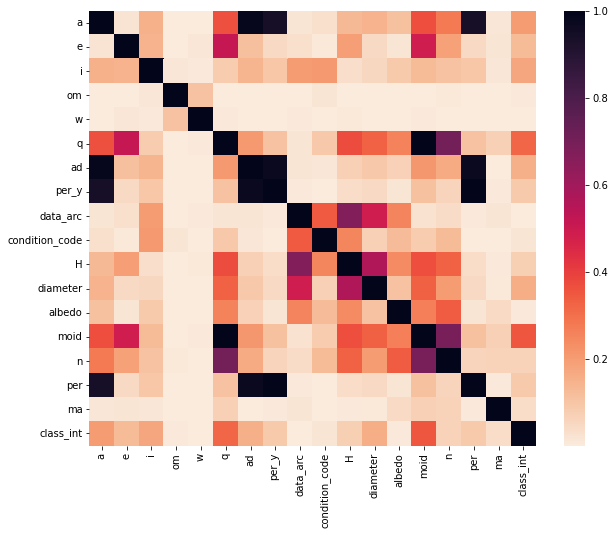

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [19]:
df.corr()['diameter'].sort_values(ascending=False)

diameter          1.000000
data_arc          0.491580
moid              0.332423
q                 0.329703
class_int         0.157560
a                 0.144736
ad                0.093430
i                 0.052609
per               0.048953
per_y             0.048953
ma                0.009659
w                 0.002966
om                0.001164
e                -0.049133
condition_code   -0.073413
albedo           -0.107334
n                -0.201023
H                -0.568493
Name: diameter, dtype: float64

# Analyzing the Correlations
I'm still left with quite a few features here, so I think it would likely be worthwhile to drop a few features that don't seem to have much correlation with the diameter of the asteroid. From the correlation check, the features that hold little correlation with the diameter are essentially the ones that would be expected. "w" and "om" are the argument of perihelion and the longitude of the ascending node, respectively. These are too general to do much good here. "ma" or the mean-anomaly also makes sense here, it just doesn't really have any meaningful correlation.

I also noticed that per_y and per had the same correlation, and realized that one was the period in years, while the other was the period in days. I decided I only needed one.

In [20]:
df.drop('w',axis=1,inplace=True)
df.drop('om',axis=1,inplace=True)
df.drop('ma',axis=1,inplace=True)
df.drop('per_y',axis=1,inplace=True)

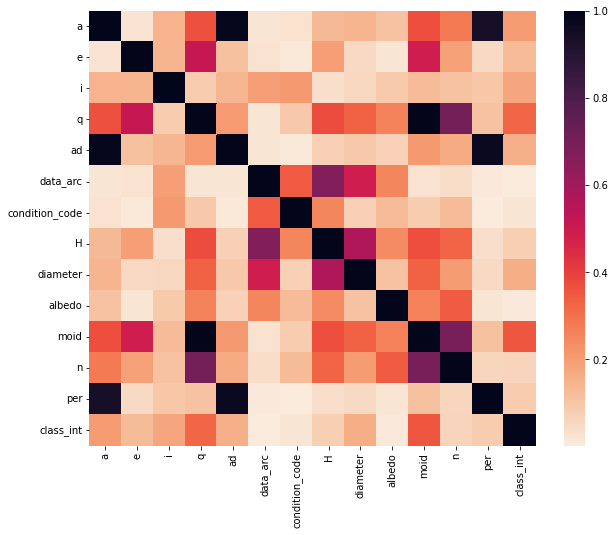

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [22]:
df.corr()['diameter'].sort_values(ascending=False)

diameter          1.000000
data_arc          0.491580
moid              0.332423
q                 0.329703
class_int         0.157560
a                 0.144736
ad                0.093430
i                 0.052609
per               0.048953
e                -0.049133
condition_code   -0.073413
albedo           -0.107334
n                -0.201023
H                -0.568493
Name: diameter, dtype: float64

# Partitioning the Data


In [23]:
# independent variables
x = df.drop(['diameter'],axis=1)
# dependent/target
y = df.diameter.values

# Separate Training, Validation and Test Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Feature Scaling

In [24]:
transformer = Normalizer(norm='max').fit(x)
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)
x_valid = transformer.transform(x_valid)

# Keras

I learned to use the keras module to skip most of the work generating the minutiae of neural networks.

After a lot of testing and experimentation, I settled on using Relu as the activation function, as it performed the best of all of those that I tried.

I also settled on filling my 2 hidden layers with 100 nodes each, after experimenting with values between 10 and approx 250.

Similarly, I decided to use adam as my optimizer, though adamax performed nearly as well. SGD was by far the worst, failing to optimize the training much at all.

Finally, for the loss function, I went with MAE, or Mean Absolute Error, as it performed better overall than MSE (Mean Squared Error), the only other one that seemed to fit well.

# Further Design Implementation

As for the desired results of the model, I wanted to emphasize the importance of determining the order of magnitude of the size of the asteroids. With that in mind, the sizes of the asteroids included in the dataset extend from a tenth of a meter to nearly a kilometer. To this end, I decided that the model should attempt to predict the exponent to which 2 should be raised to generate the desired diameter. To accomplish this, I have added 2 functions to the start of this file, capable of transforming the y values into their related exponents and vice versa.

In [25]:
input_shape=[x.shape[1]]
print(input_shape)
ast_model = tf.keras.Sequential([
 
    tf.keras.layers.Dense(units=100, activation='relu',
                          input_shape=input_shape),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
ast_model.summary()

[13]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


In [26]:
ast_model.compile(optimizer='adam', loss='mae') 

In [27]:
y_check_train = translate_y(y_train)
y_check_valid = translate_y(y_valid)
losses = ast_model.fit(x_train, y_check_train, validation_data=(x_valid, y_check_valid), batch_size=256, epochs=200)

Epoch 1/200
388/388 [==============================] - 2s 4ms/step - loss: 1.1403 - val_loss: 0.6586
Epoch 2/200
388/388 [==============================] - 1s 4ms/step - loss: 0.6552 - val_loss: 0.6554
Epoch 3/200
388/388 [==============================] - 1s 3ms/step - loss: 0.6525 - val_loss: 0.6501
Epoch 4/200
388/388 [==============================] - 1s 3ms/step - loss: 0.6481 - val_loss: 0.6463
Epoch 5/200
388/388 [==============================] - 1s 3ms/step - loss: 0.6424 - val_loss: 0.6397
Epoch 6/200
388/388 [==============================] - 1s 3ms/step - loss: 0.6365 - val_loss: 0.6319
Epoch 7/200
388/388 [==============================] - 1s 3ms/step - loss: 0.6260 - val_loss: 0.6258
Epoch 8/200
388/388 [==============================] - 1s 3ms/step - loss: 0.6137 - val_loss: 0.6062
Epoch 9/200
388/388 [==============================] - 1s 3ms/step - loss: 0.5963 - val_loss: 0.5896
Epoch 10/200
388/388 [==============================] - 1s 3ms/step - loss: 0.5720 - val_lo

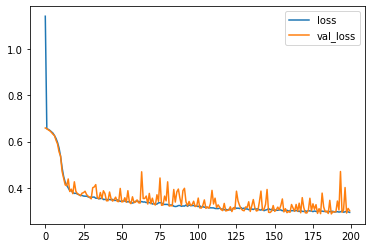

In [28]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()

For reference, the output layer of the system generates values between 0 and 14, inclusive. I could have divided it by 14 to fit it into 0 to 1, but I didn't because I got the same results and it was easier to explain.

In [29]:
pred = ast_model.predict(x_valid).flatten()
print("VALIDATION SET: Average Error is {:.2f}% of the Diameter of the Asteroid".format(perc_error(untranslate_y(pred),y_valid)*100))

VALIDATION SET: Average Error is 19.82% of the Diameter of the Asteroid


In [30]:
pred = ast_model.predict(x_test).flatten()
print("TEST SET: Average Error is {:.2f}% of the Diameter of the Asteroid".format(perc_error(untranslate_y(pred),y_test)*100))

TEST SET: Average Error is 19.91% of the Diameter of the Asteroid


As can be seen, the model is capable of predicting the diameter of a given asteroid with an error of approximately 20% of that asteroid's diameter. That's not bad. Whether predicting an asteroid of diameter = 1 meter as having a diameter of 1.2 meters or predicting one of diameter 100 meters as 120 is pretty solid.

That loss function continues to give diminishing returns as the number of epochs grows. I have run the model for 1000 epochs, and while the 

From how the loss on both the training and validation sets seem very low, it would appear that the model is generalizing well. Admittedly, the variance of the validation set seems to jump around increasingly as the model continues to train.

I did not end up using any form of regularization, as I did not come across a way within the library to accomplish that task.

# Alternate Method
For my alternate method, I am going to try and implement a Decision Tree to accomplish the same task.

In [31]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train,translate_y(y_train))
pred_tree = dtr.predict(x_valid)
pred_tree = untranslate_y(pred_tree)
print("VALIDATION SET: Average Error is {:.2f}% of the Diameter of the Asteroid".format(perc_error(pred_tree,y_valid)*100))

VALIDATION SET: Average Error is 15.41% of the Diameter of the Asteroid


In [32]:
pred_tree = dtr.predict(x_test)
pred_tree = untranslate_y(pred_tree)
print("TEST SET: Average Error is {:.2f}% of the Diameter of the Asteroid".format(perc_error(pred_tree,y_test)*100))

TEST SET: Average Error is 15.23% of the Diameter of the Asteroid


Well, that's an egg on my face. Admittedly, the problem started off seeming more complicated than it ended up being. I mean in the end I was only working with 14 features, and most of them were probably pretty linear. It's pretty embarassing that the decision tree is able to beat the average error of the neural network after functionally no computation time, whereas my model must have trained for 10 minutes.

So, it makes sense that the tree model would do better. The problem is pretty straighforward relative to the features that were passed into it, and I had a whole lot of data to work with.